In [1]:
%matplotlib inline

import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import matplotlib as mpl
import matplotlib.pyplot as plt

from svgd import svgd

Let $x_1, \dots, x_n$ be the samples generated after $L$ steps of SVGD. The function `get_mse` computes three squared error values:
* SE$_1 = (E[X] - 1/n \sum_i x_i)^2$
* SE$_2 = (E[X^2] - 1/n \sum_i x_i^2)^2$
* SE$_3 = (E[\cos(\omega X)] - 1/n \sum_i \cos(\omega X))^2$

and averages them all over `m` random seeds to get three MSE values.

In [2]:
def get_mse(logp, n, d, stepsize, L, m, q, kernel_param, kernel_param_update_rule=None):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * d: integer, particle dimension
    * stepsize: float
    * L: integer, number of SVGD steps
    * m: integer, number of samples for averaging MSE
    * q: callable, takes as argument a seed key and outputs samples of initial distributio q0
    * kernel_param: positive scalar, bandwidth parameter for RBF kernel
    * kernel_param_update_rule: callable, takes the updated particles as input and outputs an updated set of kernel parameters.

    OUT:
    * dictionary of MSE values

    """
    mse1 = []
    mse2 = []
    mse3 = []
    for seed in range(0, m):
        key = random.PRNGKey(seed)
        x = q(key, n, d)

        xout, log = svgd(x, logp, stepsize, L, kernel_param, kernel_param_update_rule)
        mse1.append((np.mean(xout, axis=0) - 2/3)**2)
        mse2.append((np.mean(xout**2, axis=0) - 5)**2)

        w = random.normal(key, (1,))
        mse3.append((np.mean(np.cos(w * xout), axis=0) - np.exp(-w**2 / 2))**2)

    mse1 = np.mean(np.array(mse1), axis=0)
    mse2 = np.mean(np.array(mse2), axis=0)
    mse3 = np.mean(np.array(mse3), axis=0)

    mse = {
    "E[x]": mse1,
    "E[x^2]": mse2,
    "E[cos(wx)]": mse3
    }
    
    return mse

In [3]:
default_q = lambda key, n, d: random.normal(key, shape=(n,d)) - 10
def kernel_param_search(logp, n, d, stepsize, L, m, kernel_param_grid, q=default_q):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * d: integer, particle dimension
    * stepsize: float
    * L: integer, number of SVGD steps
    * kernel_param_grid: one-dimensional np array
    * m: integer, number of samples for computing MSE
    * q: callable, takes as argument a seed key and outputs samples of initial distributio q0

    
    OUT:
    * dictionary consisting of three np arrays of the same length as kernel_param_grid. Entries are MSE values.
    """
    logs = []
    mse1s = []
    mse2s = []
    mse3s = []

    for h in kernel_param_grid:
        mse1, mse2, mse3 = list(get_mse(logp, n, d, stepsize, L, m, q, h).values())
        
        mse1s.append(mse1)
        mse2s.append(mse2)
        mse3s.append(mse3)
    
    mses = {
        "E[x]": np.array(mse1s),
        "E[x^2]": np.array(mse2s),
        "E[cos(wx)]": np.array(mse3s)
    }
    
    return mses

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:122: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


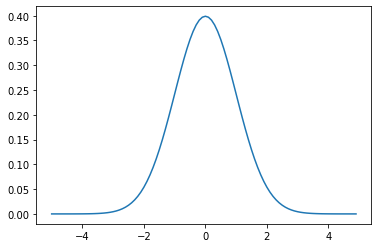

In [4]:
from jax.scipy.stats import norm

logp = lambda x: np.sum(norm.logpdf(x, loc=0, scale=1))
grid = np.arange(-5, 5, 0.1)
vlogp = vmap(logp)
_ = plt.plot(grid, np.exp(vlogp(grid)))

In [5]:
n = 100
d = 3
stepsize = 0.01
L = int(1 / stepsize)
key = random.PRNGKey(0)
# kernel_param_grid_old = np.logspace(-10, 15, num=25, base=2) # params smaller than 2^10 are generally awful

# kernel_param_grid = random.uniform(key, shape=(25, d)) * 25 - 10
# kernel_param_grid = 2**kernel_param_grid
# kernel_param_grid = kernel_param_grid[kernel_param_grid[:, 0].argsort()]

kernel_param_grid = np.logspace(-10, 15, num=25, base=2)
kernel_param_grid = np.concatenate([kernel_param_grid[:, np.newaxis], np.ones((25, 1)), np.ones((25, 1))], axis=1)

m = 30


q1 = lambda key, n, d: random.normal(key, shape=(n,d)) - 10
q2 = lambda key, n, d: random.normal(key, shape=(n,d)) * 2 + 10

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4665: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))
/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lax/lax.py:4665: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [24]:
mses1 = kernel_param_search(logp, n, d, stepsize, L, m, kernel_param_grid, q1)
mses2 = kernel_param_search(logp, n, d, stepsize, L, m, kernel_param_grid, q2)

For comparison, do the same estimates using an adaptive kernel parameter:

In [7]:
from svgd import kernel_param_update_rule
mses_adaptive1 = get_mse(logp, n, d, stepsize, L, m, q1, kernel_param = None, kernel_param_update_rule=kernel_param_update_rule)
mses_adaptive2 = get_mse(logp, n, d, stepsize, L, m, q2, kernel_param = None, kernel_param_update_rule=kernel_param_update_rule)

In [26]:
mses_adaptive1

{'E[x]': DeviceArray([18.289555, 18.255764, 18.180536], dtype=float32),
 'E[x^2]': DeviceArray([66.90888 , 66.380486, 65.39627 ], dtype=float32),
 'E[cos(wx)]': DeviceArray([0.7280354 , 0.73368657, 0.7257361 ], dtype=float32)}

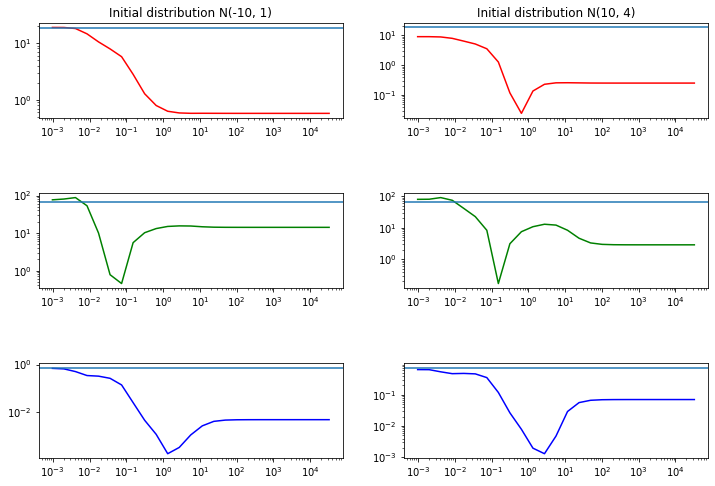

In [25]:
mpl.rcParams['figure.figsize'] = [12.0, 8.0]
plt.subplots_adjust(hspace=0.8)
i = 0

### first q
mses = mses1
mses_adaptive = mses_adaptive1
plt.subplot(321)
plt.title("Initial distribution N(-10, 1)")
plt.plot(kernel_param_grid[:, i], mses['E[x]'][:, i], 'r')
plt.axhline(y=mses_adaptive["E[x]"][i])
plt.xscale('log')
plt.yscale('log')

plt.subplot(323)
plt.plot(kernel_param_grid[:, i], mses['E[x^2]'][:, i], 'g')
plt.axhline(y=mses_adaptive["E[x^2]"][i])
plt.xscale('log')
plt.yscale('log')


plt.subplot(325)
plt.plot(kernel_param_grid[:, i], mses['E[cos(wx)]'][:, i], 'b')
plt.axhline(y=mses_adaptive["E[cos(wx)]"][i])
plt.xscale('log')
plt.yscale('log')


####################
### second q
mses = mses2
plt.subplot(322)
plt.title("Initial distribution N(10, 4)")
plt.plot(kernel_param_grid[:, i], mses['E[x]'][:, i], 'r')
plt.axhline(y=mses_adaptive["E[x]"][i])
plt.xscale('log')
plt.yscale('log')

plt.subplot(324)
plt.plot(kernel_param_grid[:, i], mses['E[x^2]'][:, i], 'g')
plt.axhline(y=mses_adaptive["E[x^2]"][i])
plt.xscale('log')
plt.yscale('log')


plt.subplot(326)
plt.plot(kernel_param_grid[:, i], mses['E[cos(wx)]'][:, i], 'b')
plt.axhline(y=mses_adaptive["E[cos(wx)]"][i])
plt.xscale('log')
plt.yscale('log')

Figure: Mean squared error (y-axis) vs. kernel parameter values (x-axis). The horizontal lines indicate the MSE obtained when computing the estimate using an adaptive kernel.
* Red: MSE when estimating $E[X]$.
* Green: MSE when estimating $E[X^2]$.
* Blue: MSE when estimating $E[\cos(\omega X)]$.

Columns:
* Left column: results for initial distribution $q_0 \sim \mathcal N(-10, 1)$.
* Right column: results for initial distribution $q_0 \sim \mathcal N(10, 4)$.

## Search parameters of initial distribution

In [12]:
default_q = lambda key, n, d: random.normal(key, shape=(n,d)) - 10
def q_param_search(logp, kernel_param, n, d, stepsize, L, param_grid, m=20, kernel_param_update_rule=None):
    """
    IN:
    * logp: callable, computes log(p(x)).
    * n: integer, number of particles
    * stepsize: float
    * L: integer, number of SVGD steps
    * param_grid: one-dimensional np array
    * m: integer, number of samples for computing MSE
    
    OUT:
    * dictionary consisting of three np arrays of the same length as kernel_param_grid. Entries are MSE values.
    """
    logs = []
    mse1s = []
    mse2s = []
    mse3s = []

    for param in param_grid:
        q = lambda key, n, d: random.normal(key, shape=(n,d)) * param[1] + param[0]
        mse1, mse2, mse3 = list(get_mse(logp, n, d, stepsize, L, m, q, kernel_param, kernel_param_update_rule).values())

        mse1s.append(mse1)
        mse2s.append(mse2)
        mse3s.append(mse3)
        
        mse1 = np.array(mse1)
        mse2 = np.array(mse2)
        mse3 = np.array(mse3)

    mses = {
        "E[x]": mse1s,
        "E[x^2]": mse2s,
        "E[cos(wx)]": mse3s
    }
    
    return mses


In [13]:
n = 100
stepsize = 0.01
L = int(1 / stepsize)
stdev = 1
param_grid = [(mean, stdev) for mean in np.arange(-20, 20, 1)]
m = 30
kernel_param = 5

In [14]:
from svgd import kernel_param_update_rule

mses3 = q_param_search(logp, kernel_param, n, d, stepsize, L, param_grid, m)
mses4 = q_param_search(logp, None, n, d, stepsize, L, param_grid, m, kernel_param_update_rule)

param_grid = [param[0] for param in param_grid] # just wanna plot wrt the means

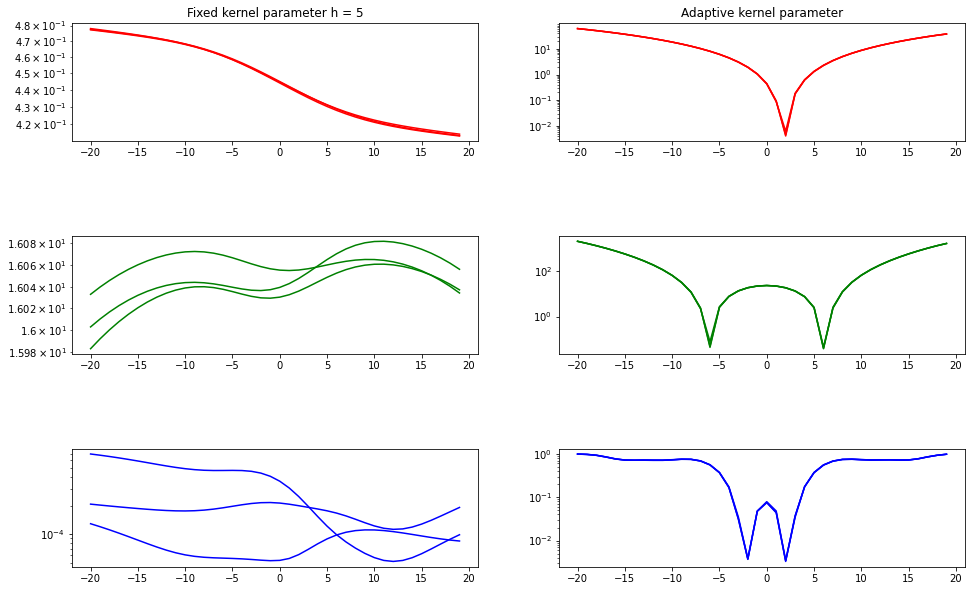

In [23]:
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
plt.subplots_adjust(hspace=0.8)

### fixed kernel parameter
mses = mses3
plt.subplot(321)
plt.title(f"Fixed kernel parameter h = {kernel_param}")
plt.plot(param_grid, mses['E[x]'], 'r')
plt.yscale('log')

plt.subplot(323)
plt.plot(param_grid, mses['E[x^2]'], 'g')
plt.yscale('log')

plt.subplot(325)
plt.plot(param_grid, mses['E[cos(wx)]'], 'b')
plt.yscale('log')

############################
### adaptive kernel parameter
mses = mses4
plt.subplot(322)
plt.title("Adaptive kernel parameter")
plt.plot(param_grid, mses['E[x]'], 'r')
plt.yscale('log')

plt.subplot(324)
plt.plot(param_grid, mses['E[x^2]'], 'g')
plt.yscale('log')

plt.subplot(326)
plt.plot(param_grid, mses['E[cos(wx)]'], 'b')
plt.yscale('log')